<a href="https://colab.research.google.com/github/tomradch/MSCIDS_Computational_Language_Technologies/blob/main/4_2_intro_to_cnn_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reviews classification

In this notebook, we will address the problem of text classification (movie reviews) and reproduce the CNN proposed by [Kim et al. (2014)](https://arxiv.org/pdf/1408.5882.pdf). A [follow-up work](https://arxiv.org/pdf/1510.03820.pdf) discusses the practical aspects.

Before starting, let's verify that we have a GPU available. If not, please change the runtime type **Runtime -> change runtime type -> hardware accelerator -> GPU**.

In [ ]:
!nvidia-smi

Sat Apr 29 08:49:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Read and split data

Let's download the official dataset and see some examples

In [ ]:
!rm rt-polaritydata*
!wget https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz
!tar -xzvf rt-polaritydata.tar.gz
!mv rt-polaritydata/rt-polarity.neg neg_reviews.txt
!mv rt-polaritydata/rt-polarity.pos pos_reviews.txt

rm: cannot remove 'rt-polaritydata*': No such file or directory
--2023-04-29 08:49:17--  https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 487770 (476K) [application/x-gzip]
Saving to: ‘rt-polaritydata.tar.gz’

rt-polaritydata.tar 100%[===================>] 476.34K  1.10MB/s    in 0.4s    

2023-04-29 08:49:18 (1.10 MB/s) - ‘rt-polaritydata.tar.gz’ saved [487770/487770]

rt-polaritydata.README.1.0.txt
rt-polaritydata/rt-polarity.neg
rt-polaritydata/rt-polarity.pos


In [ ]:
!ls

neg_reviews.txt  rt-polaritydata		 rt-polaritydata.tar.gz
pos_reviews.txt  rt-polaritydata.README.1.0.txt  sample_data


In [ ]:
reviews = {'pos': [],
           'neg': [],
           }

# Iterate over the dataset, tokenize and store the sentiment
for sentiment in reviews.keys():
  with open('{}_reviews.txt'.format(sentiment), 'r', encoding='latin-1') as fp:
    for line in fp:
      line = line.strip()
      if line != '':
        tokens = line.lower().split()
        reviews[sentiment].append(tokens)
  
  print(len(reviews[sentiment]), '{} reviews'.format(sentiment))
  print(reviews[sentiment][0])
  print(reviews[sentiment][1])
  print()

5331 pos reviews
['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', "century's", 'new', '"', 'conan', '"', 'and', 'that', "he's", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', ',', 'jean-claud', 'van', 'damme', 'or', 'steven', 'segal', '.']
['the', 'gorgeously', 'elaborate', 'continuation', 'of', '"', 'the', 'lord', 'of', 'the', 'rings', '"', 'trilogy', 'is', 'so', 'huge', 'that', 'a', 'column', 'of', 'words', 'cannot', 'adequately', 'describe', 'co-writer/director', 'peter', "jackson's", 'expanded', 'vision', 'of', 'j', '.', 'r', '.', 'r', '.', "tolkien's", 'middle-earth', '.']

5331 neg reviews
['simplistic', ',', 'silly', 'and', 'tedious', '.']
["it's", 'so', 'laddish', 'and', 'juvenile', ',', 'only', 'teenage', 'boys', 'could', 'possibly', 'find', 'it', 'funny', '.']



The data is already preprocessed (e.g., tokenized), so there is no need for additional work. Let's prepare the label for each review. We assume that the label is binary where 1 means that the review is positive and 0 negative.

In [ ]:
reviews_original = [{'tokens': review, 'sentiment':1, 'text': ' '.join(review)} for review in reviews['pos']] + \
                   [{'tokens': review, 'sentiment':0, 'text': ' '.join(review)} for review in reviews['neg']]
len(reviews_original)

10662

Before spliting the data into training, validation, and testing, it is a good practice to set all the random seeds for reproducibility purposes.

In [ ]:
import numpy as np
import math
import random
import copy
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# We make a deep copy of the reviews and shuffle the data for the train, val, test split!
data = copy.deepcopy(reviews_original)
random.shuffle(data)

# We define how to split the data
split_train = int(len(data) * 0.8)
split_val = (len(data) - split_train) // 2
split_test = len(data) - split_train - split_val

train_data = data[:split_train]
data = data[split_train:]

val_data = data[:split_val]
data = data[split_val:]

test_data = data

# Sanity check
assert len(train_data + val_data + test_data) == len(reviews_original)
assert len(set((' '.join(sample['tokens']), sample['sentiment']) for sample in (train_data + val_data + test_data))) == len(reviews_original)

In [ ]:
len(train_data), len(val_data), len(test_data) 

(8529, 1066, 1067)

In [ ]:
len(reviews_original)

10662

# Build the vocabulary and word embedding matrix

We now have all our data. Let's build the vocabulary and prepare the word-embeddings for the next steps.

In [ ]:
vocabulary = set()

for sample in train_data: # Pay attention we only use the training set!
  for token in sample['tokens']:
    vocabulary.add(token)
len(vocabulary)

19056

In this case, we do not have too many words so there is no need to filter/reduce the vocabulary (< 30k is usually good enough). Typically, we could use a frequency approach and removes words appearing less than X times.

In [ ]:
# Create the mappindg word - index and vice-versa
word2idx = {'_PAD_': 0, '_UNK_': 1}
for word in vocabulary:
  word2idx[word] = len(word2idx)
idx2word = {idx:word for word, idx in word2idx.items()}
word2idx

{'_PAD_': 0,
 '_UNK_': 1,
 'respectively': 2,
 'shipping': 3,
 'nocturnal': 4,
 '18th-century': 5,
 'spinoffs': 6,
 'marvelously': 7,
 'coma': 8,
 "jie's": 9,
 'melts': 10,
 'mistakes': 11,
 'picaresque': 12,
 'manifestations': 13,
 'acontecimentos': 14,
 'bug-eye': 15,
 'freely': 16,
 'sack': 17,
 'kitschy': 18,
 'receive': 19,
 'danish': 20,
 'improperly': 21,
 'so-so': 22,
 'arwen': 23,
 'actually': 24,
 'flurries': 25,
 'alice': 26,
 "ratliff's": 27,
 'sparse': 28,
 'champion': 29,
 'uneventful': 30,
 'entertains': 31,
 'grains': 32,
 'putty': 33,
 'soufflé': 34,
 'landscapes': 35,
 'funky': 36,
 'occurrences': 37,
 'coughed': 38,
 'for-fans': 39,
 'instantly': 40,
 'most': 41,
 'van': 42,
 'fabricated': 43,
 'icon': 44,
 'mystery/thriller': 45,
 'jarvis': 46,
 'absence': 47,
 'merchandised-to-the-max': 48,
 'force-feed': 49,
 'stepmom': 50,
 'crises': 51,
 "cagney's": 52,
 'preemptive': 53,
 'media': 54,
 'establishment': 55,
 'coldest': 56,
 'knowing': 57,
 'commander-in-chief': 

In [ ]:
idx2word

{0: '_PAD_',
 1: '_UNK_',
 2: 'respectively',
 3: 'shipping',
 4: 'nocturnal',
 5: '18th-century',
 6: 'spinoffs',
 7: 'marvelously',
 8: 'coma',
 9: "jie's",
 10: 'melts',
 11: 'mistakes',
 12: 'picaresque',
 13: 'manifestations',
 14: 'acontecimentos',
 15: 'bug-eye',
 16: 'freely',
 17: 'sack',
 18: 'kitschy',
 19: 'receive',
 20: 'danish',
 21: 'improperly',
 22: 'so-so',
 23: 'arwen',
 24: 'actually',
 25: 'flurries',
 26: 'alice',
 27: "ratliff's",
 28: 'sparse',
 29: 'champion',
 30: 'uneventful',
 31: 'entertains',
 32: 'grains',
 33: 'putty',
 34: 'soufflé',
 35: 'landscapes',
 36: 'funky',
 37: 'occurrences',
 38: 'coughed',
 39: 'for-fans',
 40: 'instantly',
 41: 'most',
 42: 'van',
 43: 'fabricated',
 44: 'icon',
 45: 'mystery/thriller',
 46: 'jarvis',
 47: 'absence',
 48: 'merchandised-to-the-max',
 49: 'force-feed',
 50: 'stepmom',
 51: 'crises',
 52: "cagney's",
 53: 'preemptive',
 54: 'media',
 55: 'establishment',
 56: 'coldest',
 57: 'knowing',
 58: 'commander-in-chie

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-04-29 08:49:27--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-29 08:49:28--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2023-04-29 08:52:08 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [ ]:
# Easier to load with gensim
WORD_DIM = 300
from gensim.models import KeyedVectors
#word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# Glove
from gensim.scripts.glove2word2vec import glove2word2vec
_ = glove2word2vec('glove.6B.300d.txt', 'glove.6B.300d_w2v.txt')
word2vec = KeyedVectors.load_word2vec_format('glove.6B.300d_w2v.txt', binary=False)

<ipython-input-14-72744d343bbe>:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  _ = glove2word2vec('glove.6B.300d.txt', 'glove.6B.300d_w2v.txt')


In [ ]:
# Now we create the word embedding matrix and copy from word2vec embeddings!

# Initialize randomly the word embedding matrix
word_embeddings = np.random.rand(len(word2idx), WORD_DIM)

# Set the values to 0 for padding
word_embeddings[word2idx['_PAD_']] = np.zeros(WORD_DIM)

# Copy from word2vec
for word in vocabulary:
  if word in word2vec:
    word_embeddings[word2idx[word], :] = word2vec[word]
word_embeddings.shape

(19058, 300)

# Process the data.

Now, we can add the word embedding indeces to our data to be fed to the model. Let's see what is there so far.

In [ ]:
train_data[0]

{'tokens': ['chicago',
  'is',
  ',',
  'in',
  'many',
  'ways',
  ',',
  'an',
  'admirable',
  'achievement',
  '.'],
 'sentiment': 1,
 'text': 'chicago is , in many ways , an admirable achievement .'}

Good. Let's add an attribute `word_idx` to all samples. In case a word is unknown, we will simply replace it with the work "_UNK_".

In [ ]:
# We add the word indeces to all data splits
for split_data in [train_data, val_data, test_data]:
  for sample in split_data:
    sample['word_idx'] = []
    for token in sample['tokens']:
      # If a word is not in our vocabulary, we put the UNK token instead
      sample['word_idx'].append(word2idx[token] if token in word2idx else word2idx['_UNK_'])

Great! We are nearly there. The last problem to address is to have the same length for the reviews. A simple way is to pad each sample until reaching the maximum length.

Let's see what is the longest review so far.

In [ ]:
max(len(sample['tokens']) for sample in train_data), \
max(len(sample['tokens']) for sample in val_data), \
max(len(sample['tokens']) for sample in test_data)

(59, 51, 51)

Now, the last step is to pad all reviews to 59 tokens!

In [ ]:
PAD_LENGTH = 59

for split_data in [train_data, val_data, test_data]:
  for sample in split_data:
    while len(sample['word_idx']) < PAD_LENGTH:
      sample['word_idx'].append(word2idx['_PAD_'])
    
    # Sanity check
    assert len(sample['word_idx']) == PAD_LENGTH

In [ ]:
train_data[0]

{'tokens': ['chicago',
  'is',
  ',',
  'in',
  'many',
  'ways',
  ',',
  'an',
  'admirable',
  'achievement',
  '.'],
 'sentiment': 1,
 'text': 'chicago is , in many ways , an admirable achievement .',
 'word_idx': [12099,
  6787,
  16337,
  603,
  4290,
  6665,
  16337,
  4905,
  15653,
  9575,
  18915,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

# Modeling

Now we can start designing our model. In Kim et al. 2014, the authors proposed the following one: 

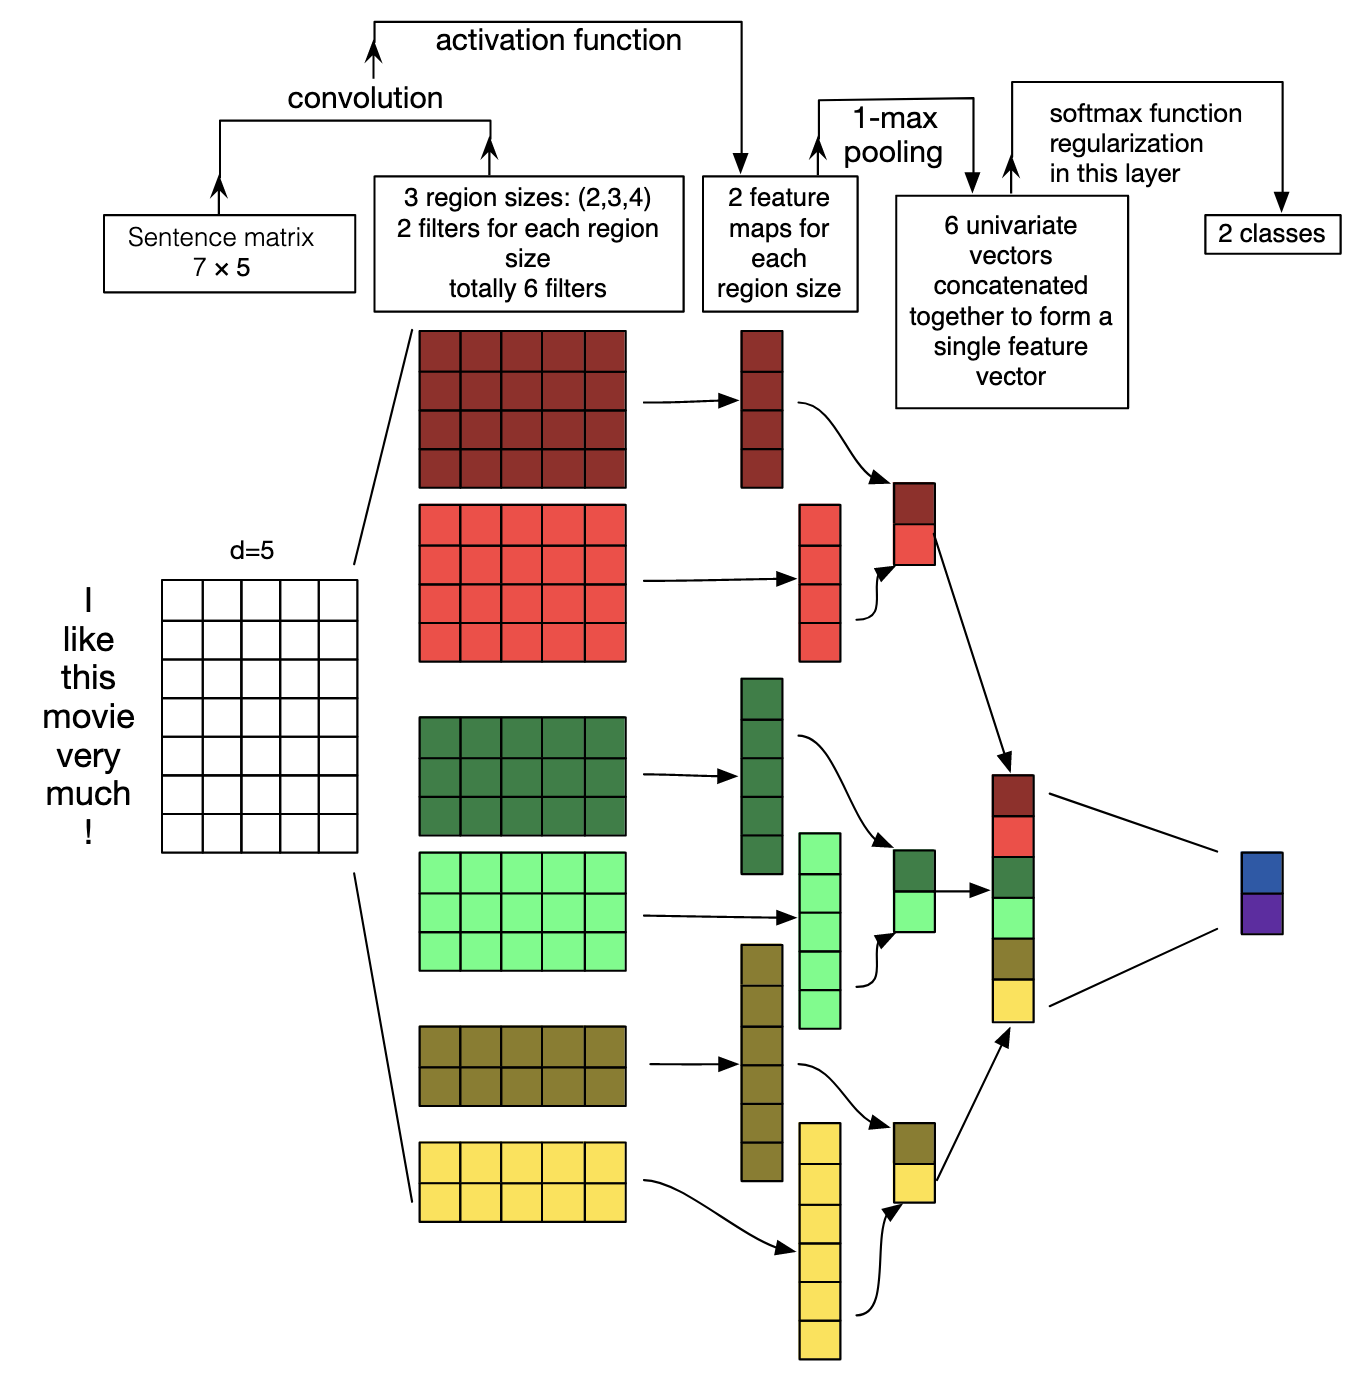

For the details, we will implement the "CNN-static" model:
- Static word embedding from word2vec with 300 dimensions (not fine-tuned)
- 100 filters/kernel/features map for each window size of 3,4,5 (i.e., n-grams)
- Max pooling to reduce the size followed by a projection layer to the output
- Dropout of 50%
- L2 weight

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, dropout, filter_num, classes_num, words_num):
        super(CNN, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=words_num, embedding_dim=input_size)

        # We create the convolution layers
        self.conv_3 = nn.Conv1d(in_channels=input_size, out_channels=filter_num, kernel_size=3)
        self.conv_4 = nn.Conv1d(in_channels=input_size, out_channels=filter_num, kernel_size=4)
        self.conv_5 = nn.Conv1d(in_channels=input_size, out_channels=filter_num, kernel_size=5)       
        self.convs = [(self.conv_3, 3), 
                      (self.conv_4, 4),
                      (self.conv_5, 5),
                      ]

        self.dropout = nn.Dropout(dropout)
        self.activation = nn.Tanh()

        # The last layer to compute the probabilities for the output classes
        self.final_layer = nn.Linear(in_features=len(self.convs) * filter_num, out_features=classes_num)
        
    def forward(self, x):
        x = self.embedding(x) # Convert into word embeddings
        x = torch.transpose(x, 1, 2) # Switch X to (Batch, Embed, Length) --> CF Doc https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html?highlight=conv1d#torch.nn.Conv1d
        x = self.dropout(x)

        output = []
        for conv, kernel_size in self.convs:
            # To have consistent dimension output, we always pad the input
            padded_activ = F.pad(x, pad=(kernel_size - 1, 0), mode='constant', value=0) #BxDx(L+K-1)

            # We do the convolution followed by an activation function
            result = self.activation(conv(padded_activ))

            # We max-pool
            result = F.max_pool1d(result, result.size(2)).squeeze(-1) #BxD
            
            # We store the result and move to the next convolution
            output.append(result)

        # concat across channels -> 3 x result.size(2)
        output = torch.cat(output, 1)
        output = self.dropout(output)
        
        # Compute the log probabilities. We do not compute the probabilities with Softmax because depending the loss function, we might require unnormalized or probabilities.
        # Worst case, we can always apply F.softmax(output, dim=-1) later.
        logits = self.final_layer(output)
        return logits

Let's see if our model can compute a foward pass

In [ ]:
# Example of a batch=1 and 6 word indeces
input = torch.tensor([[0,1,2,3,4,5]])
input

tensor([[0, 1, 2, 3, 4, 5]])

In [ ]:
cnn = CNN(input_size=300, dropout=0.5, filter_num=100, classes_num=2, words_num=6)
logits = cnn(input)
F.softmax(logits, dim=-1)

tensor([[0.4311, 0.5689]], grad_fn=<SoftmaxBackward0>)

Great! The model seems to work and is able to compute the sentiment probability of a document.

# Loss function

What is the loss to use to optimize the model? Because we are doing binary text classification, the most natural one is to use the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=cross%20entropy#torch.nn.CrossEntropyLoss). Let's see some examples

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='none')

If you lookt at the documentation, it is written that CrossEntropyLoss takes as input **unnormalized** data! (i.e., NOT probabilities).

Let's see what happens if we feed directly probabilities

In [ ]:
pred = torch.tensor([[0.0, 1.0], [0.25, 0.75], [0.5, 0.5], [0.75, 0.25], [0.99, 0.01]]) # Assumed this has been computed by a model
gold = torch.tensor([ 1       ,   1          , 1         ,  1          ,  1]) # The targets: everything must be positive
F.cross_entropy(pred, gold, reduction='none')

tensor([0.3133, 0.4741, 0.6931, 0.9741, 1.2987])

We note that the loss is not 0 when the prediction is correct but 0.3133! However, if we "unnormalize" the data (solely for illustration purposes), we observe that the results make sense

In [ ]:
def inv_softmax(x):
  return x.log() + math.log(10.)

pred = inv_softmax(torch.tensor([[0.0, 1.0], [0.25, 0.75], [0.5, 0.5], [0.75, 0.25], [0.99, 0.01]])) # Assumed this has been computed by a model
gold = torch.tensor([ 1       ,   1          , 1         ,  1          ,  1]) # The target: everything must be positive
F.cross_entropy(pred, gold, reduction='none')

tensor([-0.0000, 0.2877, 0.6931, 1.3863, 4.6052])

Indeed, when the prediction is correct, we obtain a loss of 0! and In the worst case, a loss of 4.6.

# Metric

As our task implies binary classification and the distribution of data is balanced originally, we can assume accuracy is a good enough metric.

In [ ]:
from sklearn.metrics import accuracy_score
def compute_accuracy(preds, golds):
  return accuracy_score(preds, golds)

# Putting all together

We now have the model, the data, and the loss function. We are ready to implement the training loop.

In [ ]:
# We initialize our model
model = CNN(input_size=300, dropout=0.5, filter_num=100, classes_num=2, words_num=len(word2idx))

# Copy the word embedding matrix
model.embedding.weight.data = torch.from_numpy(word_embeddings).float()
model.embedding.weight.requires_grad = False # We do NOT want to fine-tune the word embedding

In [ ]:
# We initialize our optimizer to update the weights of the model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-8) # L2 = weight_decay

In [ ]:
BATCH_SIZE = 100

# Move the model to the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize the loss function
criterion = nn.CrossEntropyLoss(reduction='mean')

best_epoch = 0
best_val_so_far = 0
test_perf = 0

# TRAINING LOOP
for epoch in range(100):
  print('------------------------------------------------------------------------')
  print('Epoch: {}'.format(epoch))

  # TRAIN
  # We set the model in train mode. It will store information to compute the gradients
  # Also, the implementation of dropout, batchnorm, etc is different at training and inference time.
  model.train()

  train_losses = []
  for idx in tqdm.tqdm(range(0, len(train_data), BATCH_SIZE), desc='Training'):
    samples = train_data[idx:idx+BATCH_SIZE]

    # Create tensors for the data and move them to GPU
    X = [sample['word_idx'] for sample in samples]
    y = [sample['sentiment'] for sample in samples]
    X = torch.tensor(X).long().to(device)
    y = torch.tensor(y).long().to(device)

    # Compute the model output and the loss
    y_logits = model(X)
    loss = criterion(y_logits, y)

    # Update model parameters
    optimizer.zero_grad() # This is very important! By default, gradients are cumulated in tensors.
    loss.backward() # Now that gradients have been empties, we compute the new ones using the loss.
    optimizer.step() # We do gradient update with our optimization function (i.e., the weights of the model are updated).
  
    train_losses.append(loss.item())
  
  
  # VAL + TEST
  val_test_losses = {'val': [], 'test': []}
  val_test_accuracy = {'val': [], 'test': []}
  
  # Unlike before, we set the model in eval mode to compute correctly dropout, batchnorm etc
  model.eval()

  # We do not store information relative to gradients as we do not update the model.
  # That's the reason why inference requires less memory and is faster.
  with torch.no_grad():
    for split_data, data in [('val', val_data), ('test', test_data)]:
      for idx in tqdm.tqdm(range(0, len(data), BATCH_SIZE), desc=split_data.capitalize()):
        samples = data[idx:idx+BATCH_SIZE]

        # Create tensors for the data and move them to GPU
        X = [sample['word_idx'] for sample in samples]
        y_gold = [sample['sentiment'] for sample in samples]
        X = torch.tensor(X).long().to(device)
        y = torch.tensor(y_gold).long().to(device)

        # Compute the model output, the probabilities, and the loss
        y_logits = model(X)
        y_probs = F.softmax(y_logits, dim=-1)
        y_pred = torch.argmax(y_logits, dim=-1)

        loss = criterion(y_logits, y)
        val_test_losses[split_data].append(loss.item())

        # Compute the accuracy to evaluate our model
        accuracy = compute_accuracy(y_pred.cpu().numpy(), y_gold)
        val_test_accuracy[split_data].append(accuracy)
  
  # Monitoring
  print('Train loss: {:.4f}'.format(np.mean(train_losses)))
  print('Val   loss: {:.4f}'.format(np.mean(val_test_losses['val'])))
  print('Test  loss: {:.4f}'.format(np.mean(val_test_losses['test'])))
  print()

  val_acc = np.mean(val_test_accuracy['val'])
  test_acc = np.mean(val_test_accuracy['test'])
  print('Val   Acc: {:.4f}'.format(val_acc))
  print('Test  Acc: {:.4f}'.format(test_acc))
  print()

  if best_val_so_far < val_acc:
    best_val_so_far = val_acc
    test_perf = test_acc
    best_epoch = epoch
  
  print('Best Epoch: {}, best val accuracy: {:.4f}, test accuracy: {:.4f}'.format(best_epoch, best_val_so_far, test_perf))
  print()
  print()

------------------------------------------------------------------------
Epoch: 0


Test: 100%|██████████| 11/11 [00:00<00:00, 255.45it/s]


Train loss: 0.6953
Val   loss: 0.6590
Test  loss: 0.6641

Val   Acc: 0.6707
Test  Acc: 0.6311

Best Epoch: 0, best val accuracy: 0.6707, test accuracy: 0.6311


------------------------------------------------------------------------
Epoch: 1


Test: 100%|██████████| 11/11 [00:00<00:00, 270.27it/s]


Train loss: 0.6655
Val   loss: 0.6316
Test  loss: 0.6413

Val   Acc: 0.7066
Test  Acc: 0.6665

Best Epoch: 1, best val accuracy: 0.7066, test accuracy: 0.6665


------------------------------------------------------------------------
Epoch: 2


Test: 100%|██████████| 11/11 [00:00<00:00, 287.15it/s]


Train loss: 0.6443
Val   loss: 0.6056
Test  loss: 0.6197

Val   Acc: 0.7412
Test  Acc: 0.6942

Best Epoch: 2, best val accuracy: 0.7412, test accuracy: 0.6942


------------------------------------------------------------------------
Epoch: 3


Test: 100%|██████████| 11/11 [00:00<00:00, 299.77it/s]


Train loss: 0.6203
Val   loss: 0.5816
Test  loss: 0.5989

Val   Acc: 0.7548
Test  Acc: 0.6952

Best Epoch: 3, best val accuracy: 0.7548, test accuracy: 0.6952


------------------------------------------------------------------------
Epoch: 4


Test: 100%|██████████| 11/11 [00:00<00:00, 282.61it/s]


Train loss: 0.6013
Val   loss: 0.5608
Test  loss: 0.5793

Val   Acc: 0.7480
Test  Acc: 0.7006

Best Epoch: 3, best val accuracy: 0.7548, test accuracy: 0.6952


------------------------------------------------------------------------
Epoch: 5


Test: 100%|██████████| 11/11 [00:00<00:00, 231.43it/s]


Train loss: 0.5818
Val   loss: 0.5440
Test  loss: 0.5632

Val   Acc: 0.7444
Test  Acc: 0.7065

Best Epoch: 3, best val accuracy: 0.7548, test accuracy: 0.6952


------------------------------------------------------------------------
Epoch: 6


Test: 100%|██████████| 11/11 [00:00<00:00, 285.78it/s]


Train loss: 0.5628
Val   loss: 0.5284
Test  loss: 0.5493

Val   Acc: 0.7534
Test  Acc: 0.7097

Best Epoch: 3, best val accuracy: 0.7548, test accuracy: 0.6952


------------------------------------------------------------------------
Epoch: 7


Test: 100%|██████████| 11/11 [00:00<00:00, 290.22it/s]


Train loss: 0.5486
Val   loss: 0.5179
Test  loss: 0.5388

Val   Acc: 0.7562
Test  Acc: 0.7138

Best Epoch: 7, best val accuracy: 0.7562, test accuracy: 0.7138


------------------------------------------------------------------------
Epoch: 8


Test: 100%|██████████| 11/11 [00:00<00:00, 281.71it/s]


Train loss: 0.5370
Val   loss: 0.5078
Test  loss: 0.5293

Val   Acc: 0.7566
Test  Acc: 0.7151

Best Epoch: 8, best val accuracy: 0.7566, test accuracy: 0.7151


------------------------------------------------------------------------
Epoch: 9


Test: 100%|██████████| 11/11 [00:00<00:00, 285.54it/s]


Train loss: 0.5274
Val   loss: 0.5027
Test  loss: 0.5234

Val   Acc: 0.7598
Test  Acc: 0.7192

Best Epoch: 9, best val accuracy: 0.7598, test accuracy: 0.7192


------------------------------------------------------------------------
Epoch: 10


Test: 100%|██████████| 11/11 [00:00<00:00, 290.22it/s]


Train loss: 0.5212
Val   loss: 0.4975
Test  loss: 0.5171

Val   Acc: 0.7548
Test  Acc: 0.7260

Best Epoch: 9, best val accuracy: 0.7598, test accuracy: 0.7192


------------------------------------------------------------------------
Epoch: 11


Test: 100%|██████████| 11/11 [00:00<00:00, 282.84it/s]


Train loss: 0.5178
Val   loss: 0.4939
Test  loss: 0.5131

Val   Acc: 0.7584
Test  Acc: 0.7306

Best Epoch: 9, best val accuracy: 0.7598, test accuracy: 0.7192


------------------------------------------------------------------------
Epoch: 12


Test: 100%|██████████| 11/11 [00:00<00:00, 237.79it/s]


Train loss: 0.5086
Val   loss: 0.4916
Test  loss: 0.5088

Val   Acc: 0.7575
Test  Acc: 0.7369

Best Epoch: 9, best val accuracy: 0.7598, test accuracy: 0.7192


------------------------------------------------------------------------
Epoch: 13


Test: 100%|██████████| 11/11 [00:00<00:00, 290.53it/s]


Train loss: 0.5004
Val   loss: 0.4885
Test  loss: 0.5050

Val   Acc: 0.7621
Test  Acc: 0.7388

Best Epoch: 13, best val accuracy: 0.7621, test accuracy: 0.7388


------------------------------------------------------------------------
Epoch: 14


Test: 100%|██████████| 11/11 [00:00<00:00, 292.24it/s]


Train loss: 0.4958
Val   loss: 0.4861
Test  loss: 0.5015

Val   Acc: 0.7621
Test  Acc: 0.7397

Best Epoch: 13, best val accuracy: 0.7621, test accuracy: 0.7388


------------------------------------------------------------------------
Epoch: 15


Test: 100%|██████████| 11/11 [00:00<00:00, 243.12it/s]


Train loss: 0.4907
Val   loss: 0.4855
Test  loss: 0.4998

Val   Acc: 0.7621
Test  Acc: 0.7369

Best Epoch: 13, best val accuracy: 0.7621, test accuracy: 0.7388


------------------------------------------------------------------------
Epoch: 16


Test: 100%|██████████| 11/11 [00:00<00:00, 274.74it/s]


Train loss: 0.4867
Val   loss: 0.4822
Test  loss: 0.4962

Val   Acc: 0.7598
Test  Acc: 0.7406

Best Epoch: 13, best val accuracy: 0.7621, test accuracy: 0.7388


------------------------------------------------------------------------
Epoch: 17


Test: 100%|██████████| 11/11 [00:00<00:00, 256.79it/s]


Train loss: 0.4842
Val   loss: 0.4808
Test  loss: 0.4936

Val   Acc: 0.7639
Test  Acc: 0.7460

Best Epoch: 17, best val accuracy: 0.7639, test accuracy: 0.7460


------------------------------------------------------------------------
Epoch: 18


Test: 100%|██████████| 11/11 [00:00<00:00, 283.53it/s]


Train loss: 0.4790
Val   loss: 0.4799
Test  loss: 0.4911

Val   Acc: 0.7620
Test  Acc: 0.7479

Best Epoch: 17, best val accuracy: 0.7639, test accuracy: 0.7460


------------------------------------------------------------------------
Epoch: 19


Test: 100%|██████████| 11/11 [00:00<00:00, 284.80it/s]


Train loss: 0.4795
Val   loss: 0.4761
Test  loss: 0.4885

Val   Acc: 0.7648
Test  Acc: 0.7528

Best Epoch: 19, best val accuracy: 0.7648, test accuracy: 0.7528


------------------------------------------------------------------------
Epoch: 20


Test: 100%|██████████| 11/11 [00:00<00:00, 295.14it/s]


Train loss: 0.4756
Val   loss: 0.4779
Test  loss: 0.4876

Val   Acc: 0.7612
Test  Acc: 0.7556

Best Epoch: 19, best val accuracy: 0.7648, test accuracy: 0.7528


------------------------------------------------------------------------
Epoch: 21


Test: 100%|██████████| 11/11 [00:00<00:00, 289.77it/s]


Train loss: 0.4715
Val   loss: 0.4760
Test  loss: 0.4858

Val   Acc: 0.7593
Test  Acc: 0.7565

Best Epoch: 19, best val accuracy: 0.7648, test accuracy: 0.7528


------------------------------------------------------------------------
Epoch: 22


Test: 100%|██████████| 11/11 [00:00<00:00, 276.39it/s]


Train loss: 0.4672
Val   loss: 0.4751
Test  loss: 0.4840

Val   Acc: 0.7630
Test  Acc: 0.7565

Best Epoch: 19, best val accuracy: 0.7648, test accuracy: 0.7528


------------------------------------------------------------------------
Epoch: 23


Test: 100%|██████████| 11/11 [00:00<00:00, 276.83it/s]


Train loss: 0.4611
Val   loss: 0.4739
Test  loss: 0.4824

Val   Acc: 0.7584
Test  Acc: 0.7597

Best Epoch: 19, best val accuracy: 0.7648, test accuracy: 0.7528


------------------------------------------------------------------------
Epoch: 24


Test: 100%|██████████| 11/11 [00:00<00:00, 293.68it/s]


Train loss: 0.4564
Val   loss: 0.4726
Test  loss: 0.4804

Val   Acc: 0.7575
Test  Acc: 0.7569

Best Epoch: 19, best val accuracy: 0.7648, test accuracy: 0.7528


------------------------------------------------------------------------
Epoch: 25


Test: 100%|██████████| 11/11 [00:00<00:00, 273.49it/s]


Train loss: 0.4594
Val   loss: 0.4719
Test  loss: 0.4792

Val   Acc: 0.7607
Test  Acc: 0.7574

Best Epoch: 19, best val accuracy: 0.7648, test accuracy: 0.7528


------------------------------------------------------------------------
Epoch: 26


Test: 100%|██████████| 11/11 [00:00<00:00, 277.75it/s]


Train loss: 0.4505
Val   loss: 0.4695
Test  loss: 0.4781

Val   Acc: 0.7634
Test  Acc: 0.7565

Best Epoch: 19, best val accuracy: 0.7648, test accuracy: 0.7528


------------------------------------------------------------------------
Epoch: 27


Test: 100%|██████████| 11/11 [00:00<00:00, 288.81it/s]


Train loss: 0.4590
Val   loss: 0.4685
Test  loss: 0.4767

Val   Acc: 0.7671
Test  Acc: 0.7588

Best Epoch: 27, best val accuracy: 0.7671, test accuracy: 0.7588


------------------------------------------------------------------------
Epoch: 28


Test: 100%|██████████| 11/11 [00:00<00:00, 293.40it/s]


Train loss: 0.4435
Val   loss: 0.4681
Test  loss: 0.4760

Val   Acc: 0.7685
Test  Acc: 0.7615

Best Epoch: 28, best val accuracy: 0.7685, test accuracy: 0.7615


------------------------------------------------------------------------
Epoch: 29


Test: 100%|██████████| 11/11 [00:00<00:00, 259.44it/s]


Train loss: 0.4461
Val   loss: 0.4668
Test  loss: 0.4749

Val   Acc: 0.7662
Test  Acc: 0.7642

Best Epoch: 28, best val accuracy: 0.7685, test accuracy: 0.7615


------------------------------------------------------------------------
Epoch: 30


Test: 100%|██████████| 11/11 [00:00<00:00, 266.76it/s]


Train loss: 0.4412
Val   loss: 0.4653
Test  loss: 0.4730

Val   Acc: 0.7703
Test  Acc: 0.7642

Best Epoch: 30, best val accuracy: 0.7703, test accuracy: 0.7642


------------------------------------------------------------------------
Epoch: 31


Test: 100%|██████████| 11/11 [00:00<00:00, 237.69it/s]


Train loss: 0.4413
Val   loss: 0.4651
Test  loss: 0.4727

Val   Acc: 0.7726
Test  Acc: 0.7651

Best Epoch: 31, best val accuracy: 0.7726, test accuracy: 0.7651


------------------------------------------------------------------------
Epoch: 32


Test: 100%|██████████| 11/11 [00:00<00:00, 286.24it/s]


Train loss: 0.4378
Val   loss: 0.4647
Test  loss: 0.4722

Val   Acc: 0.7721
Test  Acc: 0.7669

Best Epoch: 31, best val accuracy: 0.7726, test accuracy: 0.7651


------------------------------------------------------------------------
Epoch: 33


Test: 100%|██████████| 11/11 [00:00<00:00, 252.97it/s]


Train loss: 0.4354
Val   loss: 0.4635
Test  loss: 0.4717

Val   Acc: 0.7694
Test  Acc: 0.7669

Best Epoch: 31, best val accuracy: 0.7726, test accuracy: 0.7651


------------------------------------------------------------------------
Epoch: 34


Test: 100%|██████████| 11/11 [00:00<00:00, 210.67it/s]


Train loss: 0.4265
Val   loss: 0.4624
Test  loss: 0.4715

Val   Acc: 0.7698
Test  Acc: 0.7610

Best Epoch: 31, best val accuracy: 0.7726, test accuracy: 0.7651


------------------------------------------------------------------------
Epoch: 35


Test: 100%|██████████| 11/11 [00:00<00:00, 280.36it/s]


Train loss: 0.4269
Val   loss: 0.4604
Test  loss: 0.4713

Val   Acc: 0.7826
Test  Acc: 0.7724

Best Epoch: 35, best val accuracy: 0.7826, test accuracy: 0.7724


------------------------------------------------------------------------
Epoch: 36


Test: 100%|██████████| 11/11 [00:00<00:00, 271.89it/s]


Train loss: 0.4185
Val   loss: 0.4614
Test  loss: 0.4715

Val   Acc: 0.7730
Test  Acc: 0.7601

Best Epoch: 35, best val accuracy: 0.7826, test accuracy: 0.7724


------------------------------------------------------------------------
Epoch: 37


Test: 100%|██████████| 11/11 [00:00<00:00, 232.07it/s]


Train loss: 0.4234
Val   loss: 0.4594
Test  loss: 0.4707

Val   Acc: 0.7780
Test  Acc: 0.7647

Best Epoch: 35, best val accuracy: 0.7826, test accuracy: 0.7724


------------------------------------------------------------------------
Epoch: 38


Test: 100%|██████████| 11/11 [00:00<00:00, 280.92it/s]


Train loss: 0.4147
Val   loss: 0.4596
Test  loss: 0.4695

Val   Acc: 0.7726
Test  Acc: 0.7669

Best Epoch: 35, best val accuracy: 0.7826, test accuracy: 0.7724


------------------------------------------------------------------------
Epoch: 39


Test: 100%|██████████| 11/11 [00:00<00:00, 280.88it/s]


Train loss: 0.4150
Val   loss: 0.4597
Test  loss: 0.4675

Val   Acc: 0.7776
Test  Acc: 0.7710

Best Epoch: 35, best val accuracy: 0.7826, test accuracy: 0.7724


------------------------------------------------------------------------
Epoch: 40


Test: 100%|██████████| 11/11 [00:00<00:00, 280.35it/s]


Train loss: 0.4071
Val   loss: 0.4584
Test  loss: 0.4666

Val   Acc: 0.7803
Test  Acc: 0.7710

Best Epoch: 35, best val accuracy: 0.7826, test accuracy: 0.7724


------------------------------------------------------------------------
Epoch: 41


Test: 100%|██████████| 11/11 [00:00<00:00, 278.42it/s]


Train loss: 0.4161
Val   loss: 0.4576
Test  loss: 0.4665

Val   Acc: 0.7749
Test  Acc: 0.7719

Best Epoch: 35, best val accuracy: 0.7826, test accuracy: 0.7724


------------------------------------------------------------------------
Epoch: 42


Test: 100%|██████████| 11/11 [00:00<00:00, 271.69it/s]


Train loss: 0.4136
Val   loss: 0.4571
Test  loss: 0.4657

Val   Acc: 0.7812
Test  Acc: 0.7692

Best Epoch: 35, best val accuracy: 0.7826, test accuracy: 0.7724


------------------------------------------------------------------------
Epoch: 43


Test: 100%|██████████| 11/11 [00:00<00:00, 263.07it/s]


Train loss: 0.4008
Val   loss: 0.4546
Test  loss: 0.4649

Val   Acc: 0.7776
Test  Acc: 0.7733

Best Epoch: 35, best val accuracy: 0.7826, test accuracy: 0.7724


------------------------------------------------------------------------
Epoch: 44


Test: 100%|██████████| 11/11 [00:00<00:00, 292.67it/s]


Train loss: 0.4013
Val   loss: 0.4547
Test  loss: 0.4655

Val   Acc: 0.7776
Test  Acc: 0.7769

Best Epoch: 35, best val accuracy: 0.7826, test accuracy: 0.7724


------------------------------------------------------------------------
Epoch: 45


Test: 100%|██████████| 11/11 [00:00<00:00, 275.93it/s]


Train loss: 0.3987
Val   loss: 0.4549
Test  loss: 0.4645

Val   Acc: 0.7826
Test  Acc: 0.7778

Best Epoch: 45, best val accuracy: 0.7826, test accuracy: 0.7778


------------------------------------------------------------------------
Epoch: 46


Test: 100%|██████████| 11/11 [00:00<00:00, 289.71it/s]


Train loss: 0.3903
Val   loss: 0.4538
Test  loss: 0.4637

Val   Acc: 0.7799
Test  Acc: 0.7769

Best Epoch: 45, best val accuracy: 0.7826, test accuracy: 0.7778


------------------------------------------------------------------------
Epoch: 47


Test: 100%|██████████| 11/11 [00:00<00:00, 259.79it/s]


Train loss: 0.3870
Val   loss: 0.4535
Test  loss: 0.4637

Val   Acc: 0.7776
Test  Acc: 0.7765

Best Epoch: 45, best val accuracy: 0.7826, test accuracy: 0.7778


------------------------------------------------------------------------
Epoch: 48


Test: 100%|██████████| 11/11 [00:00<00:00, 281.56it/s]


Train loss: 0.3862
Val   loss: 0.4572
Test  loss: 0.4639

Val   Acc: 0.7876
Test  Acc: 0.7765

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 49


Test: 100%|██████████| 11/11 [00:00<00:00, 280.37it/s]


Train loss: 0.3828
Val   loss: 0.4551
Test  loss: 0.4623

Val   Acc: 0.7753
Test  Acc: 0.7738

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 50


Test: 100%|██████████| 11/11 [00:00<00:00, 282.97it/s]


Train loss: 0.3838
Val   loss: 0.4556
Test  loss: 0.4619

Val   Acc: 0.7790
Test  Acc: 0.7774

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 51


Test: 100%|██████████| 11/11 [00:00<00:00, 271.30it/s]


Train loss: 0.3752
Val   loss: 0.4549
Test  loss: 0.4620

Val   Acc: 0.7790
Test  Acc: 0.7765

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 52


Test: 100%|██████████| 11/11 [00:00<00:00, 271.75it/s]


Train loss: 0.3776
Val   loss: 0.4527
Test  loss: 0.4616

Val   Acc: 0.7844
Test  Acc: 0.7779

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 53


Test: 100%|██████████| 11/11 [00:00<00:00, 282.08it/s]


Train loss: 0.3712
Val   loss: 0.4514
Test  loss: 0.4623

Val   Acc: 0.7799
Test  Acc: 0.7819

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 54


Test: 100%|██████████| 11/11 [00:00<00:00, 275.65it/s]


Train loss: 0.3690
Val   loss: 0.4528
Test  loss: 0.4626

Val   Acc: 0.7808
Test  Acc: 0.7828

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 55


Test: 100%|██████████| 11/11 [00:00<00:00, 272.94it/s]


Train loss: 0.3669
Val   loss: 0.4531
Test  loss: 0.4626

Val   Acc: 0.7776
Test  Acc: 0.7797

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 56


Test: 100%|██████████| 11/11 [00:00<00:00, 279.52it/s]


Train loss: 0.3596
Val   loss: 0.4517
Test  loss: 0.4621

Val   Acc: 0.7799
Test  Acc: 0.7778

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 57


Test: 100%|██████████| 11/11 [00:00<00:00, 276.92it/s]


Train loss: 0.3622
Val   loss: 0.4510
Test  loss: 0.4617

Val   Acc: 0.7740
Test  Acc: 0.7824

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 58


Test: 100%|██████████| 11/11 [00:00<00:00, 274.73it/s]


Train loss: 0.3617
Val   loss: 0.4512
Test  loss: 0.4612

Val   Acc: 0.7703
Test  Acc: 0.7838

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 59


Test: 100%|██████████| 11/11 [00:00<00:00, 284.98it/s]


Train loss: 0.3527
Val   loss: 0.4513
Test  loss: 0.4622

Val   Acc: 0.7703
Test  Acc: 0.7801

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 60


Test: 100%|██████████| 11/11 [00:00<00:00, 286.93it/s]


Train loss: 0.3520
Val   loss: 0.4515
Test  loss: 0.4626

Val   Acc: 0.7712
Test  Acc: 0.7828

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 61


Test: 100%|██████████| 11/11 [00:00<00:00, 284.78it/s]


Train loss: 0.3454
Val   loss: 0.4518
Test  loss: 0.4633

Val   Acc: 0.7749
Test  Acc: 0.7806

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 62


Test: 100%|██████████| 11/11 [00:00<00:00, 263.05it/s]


Train loss: 0.3392
Val   loss: 0.4517
Test  loss: 0.4631

Val   Acc: 0.7712
Test  Acc: 0.7788

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 63


Test: 100%|██████████| 11/11 [00:00<00:00, 286.47it/s]


Train loss: 0.3426
Val   loss: 0.4521
Test  loss: 0.4631

Val   Acc: 0.7703
Test  Acc: 0.7779

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 64


Test: 100%|██████████| 11/11 [00:00<00:00, 281.12it/s]


Train loss: 0.3438
Val   loss: 0.4518
Test  loss: 0.4626

Val   Acc: 0.7712
Test  Acc: 0.7806

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 65


Test: 100%|██████████| 11/11 [00:00<00:00, 280.69it/s]


Train loss: 0.3426
Val   loss: 0.4525
Test  loss: 0.4633

Val   Acc: 0.7735
Test  Acc: 0.7783

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 66


Test: 100%|██████████| 11/11 [00:00<00:00, 282.56it/s]


Train loss: 0.3278
Val   loss: 0.4494
Test  loss: 0.4624

Val   Acc: 0.7771
Test  Acc: 0.7765

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 67


Test: 100%|██████████| 11/11 [00:00<00:00, 283.95it/s]


Train loss: 0.3341
Val   loss: 0.4494
Test  loss: 0.4617

Val   Acc: 0.7758
Test  Acc: 0.7801

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 68


Test: 100%|██████████| 11/11 [00:00<00:00, 283.63it/s]


Train loss: 0.3294
Val   loss: 0.4511
Test  loss: 0.4623

Val   Acc: 0.7758
Test  Acc: 0.7820

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 69


Test: 100%|██████████| 11/11 [00:00<00:00, 284.58it/s]


Train loss: 0.3173
Val   loss: 0.4514
Test  loss: 0.4629

Val   Acc: 0.7758
Test  Acc: 0.7797

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 70


Test: 100%|██████████| 11/11 [00:00<00:00, 291.71it/s]


Train loss: 0.3204
Val   loss: 0.4506
Test  loss: 0.4632

Val   Acc: 0.7776
Test  Acc: 0.7788

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 71


Test: 100%|██████████| 11/11 [00:00<00:00, 267.72it/s]


Train loss: 0.3213
Val   loss: 0.4495
Test  loss: 0.4628

Val   Acc: 0.7776
Test  Acc: 0.7792

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 72


Test: 100%|██████████| 11/11 [00:00<00:00, 257.34it/s]


Train loss: 0.3150
Val   loss: 0.4527
Test  loss: 0.4635

Val   Acc: 0.7744
Test  Acc: 0.7783

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 73


Test: 100%|██████████| 11/11 [00:00<00:00, 277.88it/s]


Train loss: 0.3073
Val   loss: 0.4505
Test  loss: 0.4616

Val   Acc: 0.7731
Test  Acc: 0.7774

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 74


Test: 100%|██████████| 11/11 [00:00<00:00, 288.84it/s]


Train loss: 0.3075
Val   loss: 0.4510
Test  loss: 0.4634

Val   Acc: 0.7772
Test  Acc: 0.7797

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 75


Test: 100%|██████████| 11/11 [00:00<00:00, 271.06it/s]


Train loss: 0.3034
Val   loss: 0.4502
Test  loss: 0.4628

Val   Acc: 0.7776
Test  Acc: 0.7788

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 76


Test: 100%|██████████| 11/11 [00:00<00:00, 277.93it/s]


Train loss: 0.3060
Val   loss: 0.4534
Test  loss: 0.4635

Val   Acc: 0.7721
Test  Acc: 0.7828

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 77


Test: 100%|██████████| 11/11 [00:00<00:00, 263.44it/s]


Train loss: 0.3016
Val   loss: 0.4495
Test  loss: 0.4618

Val   Acc: 0.7785
Test  Acc: 0.7829

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 78


Test: 100%|██████████| 11/11 [00:00<00:00, 263.00it/s]


Train loss: 0.2960
Val   loss: 0.4493
Test  loss: 0.4632

Val   Acc: 0.7785
Test  Acc: 0.7824

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 79


Test: 100%|██████████| 11/11 [00:00<00:00, 283.26it/s]


Train loss: 0.2989
Val   loss: 0.4528
Test  loss: 0.4643

Val   Acc: 0.7780
Test  Acc: 0.7815

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 80


Test: 100%|██████████| 11/11 [00:00<00:00, 287.94it/s]


Train loss: 0.2922
Val   loss: 0.4510
Test  loss: 0.4631

Val   Acc: 0.7753
Test  Acc: 0.7842

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 81


Test: 100%|██████████| 11/11 [00:00<00:00, 277.84it/s]


Train loss: 0.2909
Val   loss: 0.4528
Test  loss: 0.4631

Val   Acc: 0.7712
Test  Acc: 0.7838

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 82


Test: 100%|██████████| 11/11 [00:00<00:00, 278.73it/s]


Train loss: 0.2937
Val   loss: 0.4531
Test  loss: 0.4631

Val   Acc: 0.7744
Test  Acc: 0.7842

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 83


Test: 100%|██████████| 11/11 [00:00<00:00, 276.15it/s]


Train loss: 0.2879
Val   loss: 0.4519
Test  loss: 0.4626

Val   Acc: 0.7799
Test  Acc: 0.7838

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 84


Test: 100%|██████████| 11/11 [00:00<00:00, 267.04it/s]


Train loss: 0.2862
Val   loss: 0.4539
Test  loss: 0.4634

Val   Acc: 0.7767
Test  Acc: 0.7815

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 85


Test: 100%|██████████| 11/11 [00:00<00:00, 282.03it/s]


Train loss: 0.2830
Val   loss: 0.4556
Test  loss: 0.4646

Val   Acc: 0.7749
Test  Acc: 0.7842

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 86


Test: 100%|██████████| 11/11 [00:00<00:00, 284.36it/s]


Train loss: 0.2744
Val   loss: 0.4542
Test  loss: 0.4654

Val   Acc: 0.7771
Test  Acc: 0.7788

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 87


Test: 100%|██████████| 11/11 [00:00<00:00, 271.16it/s]


Train loss: 0.2796
Val   loss: 0.4538
Test  loss: 0.4657

Val   Acc: 0.7762
Test  Acc: 0.7751

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 88


Test: 100%|██████████| 11/11 [00:00<00:00, 279.40it/s]


Train loss: 0.2687
Val   loss: 0.4553
Test  loss: 0.4652

Val   Acc: 0.7762
Test  Acc: 0.7828

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 89


Test: 100%|██████████| 11/11 [00:00<00:00, 281.94it/s]


Train loss: 0.2703
Val   loss: 0.4544
Test  loss: 0.4675

Val   Acc: 0.7785
Test  Acc: 0.7824

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 90


Test: 100%|██████████| 11/11 [00:00<00:00, 288.54it/s]


Train loss: 0.2628
Val   loss: 0.4565
Test  loss: 0.4653

Val   Acc: 0.7790
Test  Acc: 0.7910

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 91


Test: 100%|██████████| 11/11 [00:00<00:00, 277.44it/s]


Train loss: 0.2577
Val   loss: 0.4570
Test  loss: 0.4659

Val   Acc: 0.7776
Test  Acc: 0.7869

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 92


Test: 100%|██████████| 11/11 [00:00<00:00, 274.35it/s]


Train loss: 0.2651
Val   loss: 0.4575
Test  loss: 0.4650

Val   Acc: 0.7726
Test  Acc: 0.7851

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 93


Test: 100%|██████████| 11/11 [00:00<00:00, 280.60it/s]


Train loss: 0.2592
Val   loss: 0.4614
Test  loss: 0.4679

Val   Acc: 0.7703
Test  Acc: 0.7869

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 94


Test: 100%|██████████| 11/11 [00:00<00:00, 235.60it/s]


Train loss: 0.2584
Val   loss: 0.4595
Test  loss: 0.4666

Val   Acc: 0.7694
Test  Acc: 0.7833

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 95


Test: 100%|██████████| 11/11 [00:00<00:00, 268.29it/s]


Train loss: 0.2511
Val   loss: 0.4585
Test  loss: 0.4662

Val   Acc: 0.7744
Test  Acc: 0.7829

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 96


Test: 100%|██████████| 11/11 [00:00<00:00, 287.13it/s]


Train loss: 0.2508
Val   loss: 0.4586
Test  loss: 0.4666

Val   Acc: 0.7753
Test  Acc: 0.7897

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 97


Test: 100%|██████████| 11/11 [00:00<00:00, 206.24it/s]


Train loss: 0.2481
Val   loss: 0.4608
Test  loss: 0.4682

Val   Acc: 0.7708
Test  Acc: 0.7897

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 98


Test: 100%|██████████| 11/11 [00:00<00:00, 281.92it/s]


Train loss: 0.2500
Val   loss: 0.4630
Test  loss: 0.4700

Val   Acc: 0.7653
Test  Acc: 0.7919

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


------------------------------------------------------------------------
Epoch: 99


Test: 100%|██████████| 11/11 [00:00<00:00, 289.90it/s]

Train loss: 0.2492
Val   loss: 0.4619
Test  loss: 0.4698

Val   Acc: 0.7744
Test  Acc: 0.7947

Best Epoch: 48, best val accuracy: 0.7876, test accuracy: 0.7765


